# Credit Risk & Loan Performance: Data Sampling and Exploratory Data Analysis

#### Author: Satveer Kaur
#### Date: 2025-10-19
#### Notebook Purpose:
This notebook focuses on **data sampling and initial exploratory data analysis (EDA)** for the LendingClub Accepted and Rejected Loans datasets. LendingClub Accepted Loans dataset. 
The goal is to:
1. Create **representative sample datasets** for faster, efficient exploration while preserving the distribution of key variables.
2. Conduct **initial EDA**, including univariate analysis of important numerical and categorical features, to understand data structure and detect potential issues.
3. Evaluate **variable distributions, proportions, and data balance** between accepted and rejected loans
4. Prepare the groundwork for deeper **statistical analysis, feature engineering, and visualization** in subsequent notebooks.

#### 1. Load Cleaned Datasets
**Purpose**: Import the **cleaned Accepted Loans** CSV files and verify successful loading by checking their shape and basic structure. This ensures dataset is ready for sampling and further exploratory analysis.

In [ ]:
# Importing Libraries
import pandas as pd
from sklearn.model_selection import train_test_split  # for stratified sampling
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
# To see all the columns in the df
# pd.set_option('display.max_columns', False)


# Load cleaned datasets
accepted_loans = pd.read_csv("../data/clean_data/accepted_loans_cleaned.csv", low_memory=False)

print(f"Accepted Loans: {accepted_loans.shape}")

#### 2. Create Sample Datasets
**Purpose:**  
The cleaned datasets are large, which can make visualization and analysis slower. To enable efficient exploratory data analysis (EDA), we create **representative samples** that retain the overall data distribution while reducing size.  

This approach allows for faster testing, plotting, and insight generation — especially useful when working on limited local resources.

##### 2.1 Drop Rows with NaN `loan_status` and `state` and change datatype to String
**Purpose:**  
Stratified sampling requires a valid target variable. Rows with missing `loan_status` cannot be assigned to a class and the column is converted to string to ensure proper class handling in the sample.

In [ ]:
# Ensure 'loan_status' in accepted loans has no NaNs and is string type
accepted_loans.loc[:,'loan_status'] = accepted_loans.dropna(subset=['loan_status'])
accepted_loans['loan_status'] = accepted_loans['loan_status'].astype(str)
print(f"Accepted Loans: {accepted_loans.shape}, dtype: {accepted_loans['loan_status'].dtype}")


Accepted Loans: (2260701, 102), dtype: object


##### 2.2 Stratified Sampling for Accepted Loans
**Purpose:**  
To reduce dataset size while preserving class proportions, we perform stratified sampling on accepted loans (`loan_status`).

In [ ]:
# Stratified sampling for accepted loans by loan_status
accepted_sample, _ = train_test_split(
    accepted_loans,
    test_size=0.9, # keep 10% for sample 
    stratify=accepted_loans['loan_status'],
    random_state=42
)

print(f'Accepted Loans Sample: {accepted_sample.shape}')


Accepted Loans Sample: (226070, 102)


##### 2.3 Save Sampled Datasets
**Purpose:**  
To avoid resampling and ensure reproducibility, the stratified samples of accepted loans as separate CSV files. This allows faster EDA and modeling in later steps.

In [ ]:
# Save sampled datasets to CSV
accepted_sample.to_csv('../data/sample_data/accepted_sample.csv', index=False)

#### 3. Exploratory Data Analysis (EDA)
**Purpose:**  
Understand the data distributions, identify patterns, spot anomalies, and get insights that will guide feature engineering and modeling.

##### 3.1 Overview of the Data
**Purpose:**  
Get a quick summary of the numeric and categorical features, including counts, distributions, and basic statistics.

In [ ]:
# # Set float display format to 2 decimal places for better readability in summary statistics
pd.set_option('display.float_format',lambda x : '%.2f' % x)

# Numeric summary
accepted_sample.describe()

,amount_requested,funded_amount,funded_amount_invested,interest_rate,installment,annual_income,debt_to_income_ratio,delinquencies_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,open_accounts,public_records,revolving_balance,revolving_utilization,total_accounts,out_prncp,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,...,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,226067.00,226067.00,226067.00,226067.00,226067.00,226067.00,225887.00,226066.00,226067.00,226067.00,226066.00,110207.00,226066.00,226066.00,226067.00,225889.00,226066.00,226067.00,226067.00,226067.00,226067.00,226067.00,226067.00,226067.00,226067.00,226067.00,226067.00,226067.00,226056.00,226067.00,226066.00,218841.00,218841.00,139411.00,139411.00,139411.00,139411.00,134997.00,139411.00,119257.00,...,218841.00,139411.00,139411.00,139411.00,221009.00,218834.00,218612.00,218499.00,226056.00,226066.00,211964.00,218841.00,218841.00,218841.00,221009.00,218738.00,196309.00,73846.00,218841.00,218841.00,218841.00,220108.00,218841.00,218841.00,218841.00,218841.00,218841.00,220108.00,210443.00,218841.00,218841.00,218841.00,218829.00,218566.00,225936.00,226059.00,218841.00,221009.00,221009.00,218841.00
mean,15070.38,15065.51,15047.40,13.09,446.55,77962.65,18.84,0.31,698.58,702.58,0.58,34.57,11.61,0.20,16593.83,50.38,24.17,4208.24,12110.47,12092.99,9529.48,2436.11,1.56,143.32,23.89,3440.47,687.53,675.44,0.02,1.00,0.00,224.33,142517.08,0.93,2.79,0.68,1.56,21.14,35581.65,69.18,...,34514.87,1.01,1.47,2.05,4.52,13545.68,11374.55,57.91,0.01,12.43,126.00,181.63,14.01,8.28,1.56,24.78,6.99,35.82,0.50,3.68,5.63,4.78,7.73,8.43,8.24,14.00,5.57,11.63,0.00,0.00,0.08,2.08,94.10,42.46,0.13,0.05,178261.58,51078.97,23175.26,43865.30
std,9216.52,9215.14,9219.25,4.83,268.00,72516.15,15.01,0.88,33.05,33.05,0.89,21.94,5.64,0.60,22783.18,24.73,11.99,7357.38,9942.52,9938.24,8351.54,2691.52,12.38,742.99,130.68,6049.00,73.03,111.02,0.15,0.00,0.07,1805.69,159859.47,1.14,3.00,0.92,1.57,25.77,44099.20,23.82,...,40402.50,1.48,2.65,2.39,3.16,16384.85,16597.94,28.61,0.10,838.59,53.30,96.90,17.54,9.19,1.91,32.36,5.95,22.36,1.36,2.33,3.38,3.05,4.71,7.34,4.69,8.05,3.29,5.64,0.03,0.06,0.51,1.83,9.06,36.23,0.37,0.41,181342.31,49872.97,22877.56,45177.30
min,500.00,500.00,0.00,5.31,14.77,0.00,0.00,0.00,615.00,619.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,8000.00,8000.00,8000.00,9.49,252.14,46000.00,11.90,0.00,675.00,679.00,0.00,16.00,8.00,0.00,5960.00,31.60,15.00,0.00,4542.04,4528.03,3000.00,728.72,0.00,0.00,0.00,310.38,654.00,650.00,0.00,1.00,0.00,0.00,29198.00,0.00,1.00,0.00,0.00,7.00,8769.00,55.00,...,14600.00,0.00,0.00,0.00,2.00,3097.00,1719.00,35.40,0.00,0.00,96.00,117.00,4.00,3.00,0.00,6.00,2.00,17.00,0.00,2.00,3.00,3.00,4.00,3.00,5.00,8.00,3.00,8.00,0.00,0.00,0.00,1.00,91.30,0.00,0.00,0

In [ ]:
#Categorical summary of loan_status
accepted_sample['loan_status'].value_counts()

loan_status
Fully Paid                                             107675
Current                                                 87832
Charged Off                                             26856
Late (31-120 days)                                       2147
In Grace Period                                           843
Late (16-30 days)                                         435
Does not meet the credit policy. Status:Fully Paid        199
Does not meet the credit policy. Status:Charged Off        76
Default                                                     4
nan                                                         3
Name: count, dtype: int64

##### 3.2 Categorical Univariate Analysis 

##### 3.2.1 Loan Status Distribution for `Accepted Loans`
**Purpose:**  
To understand the distribution of loan outcomes, including the majority and minority categories. Small categories are grouped into `Other` for clarity.

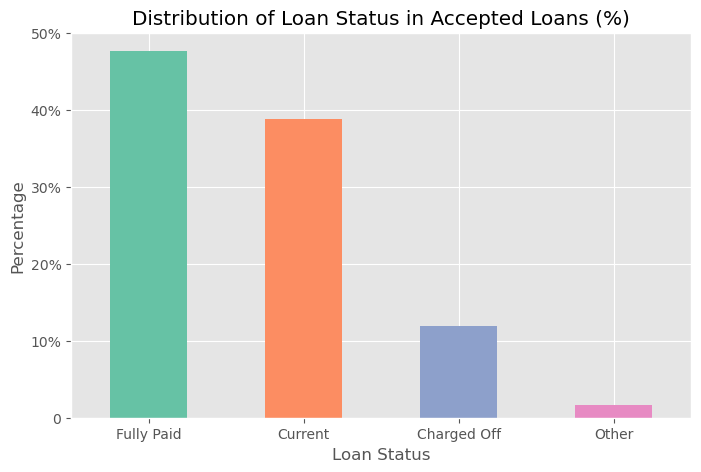

In [ ]:
# Combine small categories
top_loan_status = ['Fully Paid', 'Current','Charged Off']
accepted_sample['loan_status_grouped'] = accepted_sample['loan_status'].apply(
    lambda x: x if x in top_loan_status else 'Other'
)

#calculate percentage
loan_status_pct = accepted_sample['loan_status_grouped'].value_counts(normalize=True) * 100

#plot 
plt.figure(figsize=(8,5))
loan_status_pct.plot(kind='bar', color=sns.color_palette("Set2", 4))
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y,pos: f'{int(y)}%' if y!=0 else '0'))
plt.xlabel('Loan Status')
plt.ylabel('Percentage')
plt.title('Distribution of Loan Status in Accepted Loans (%)')
plt.xticks(rotation=0) 
plt.show()

##### 3.2.2 Loan Grades, Term, and Home Ownership for `Accepted Loans`
**Purpose:**  
To understand the distribution of key categorical features affecting credit risk and repayment patterns.

In [ ]:
# Combine small categories of home_ownership
top_home_ownership = ['MORTGAGE', 'RENT','OWN']
accepted_sample['home_ownership_grouped'] = accepted_sample['home_ownership'].apply(
    lambda x: x if x in top_home_ownership else 'Other'
)

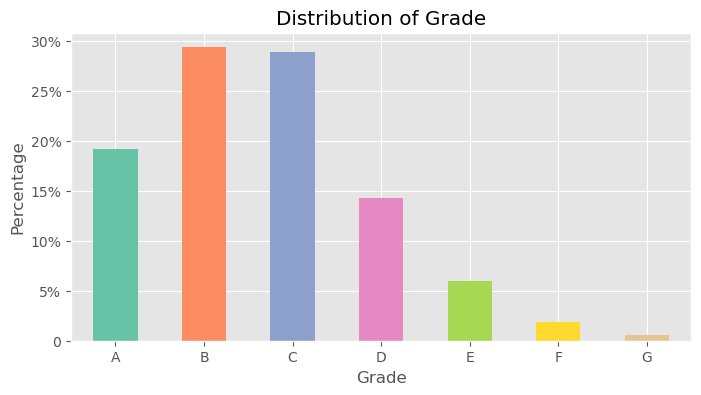

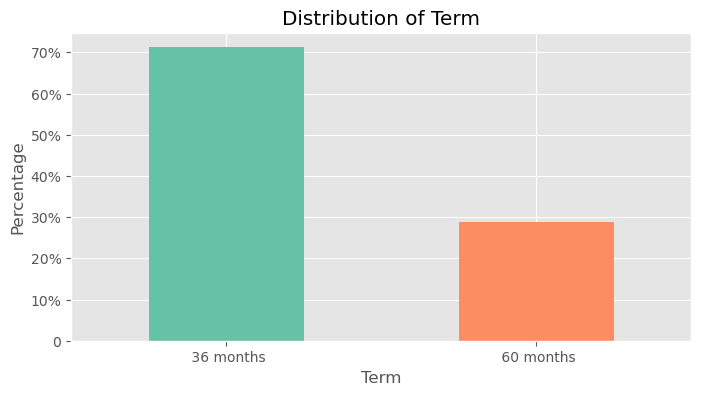

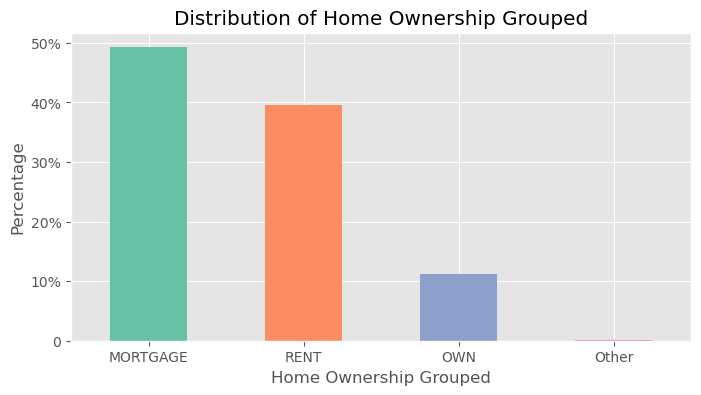

In [ ]:
categorical_cols = ['grade', 'term', 'home_ownership_grouped']
palette = sns.color_palette("Set2")  # Seaborn Set2 palette

for col in categorical_cols:
    plt.figure(figsize=(8,4))
    if col == 'home_ownership_grouped':
        counts = (accepted_sample[col].value_counts(normalize=True) * 100)
    else:
        counts = (accepted_sample[col].value_counts(normalize=True) * 100).sort_index()
    counts.plot(kind='bar', color=palette[:len(counts)])
    ax = plt.gca()
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y,pos: f'{int(y)}%' if y!=0 else '0'))
    plt.xlabel(col.replace('_', ' ').title())
    plt.ylabel('Percentage')
    plt.title(f'Distribution of {col.replace("_", " ").title()}')
    plt.xticks(rotation=0)
    plt.show()


##### 3.3 Numerical Univariate Analysis 

##### 3.3.1 Distribution of Loan Amount Requested
**Purpose:**  
To understand the typical loan amounts requested by borrowers and identify patterns or outliers that could impact credit risk assessment and lending strategies.

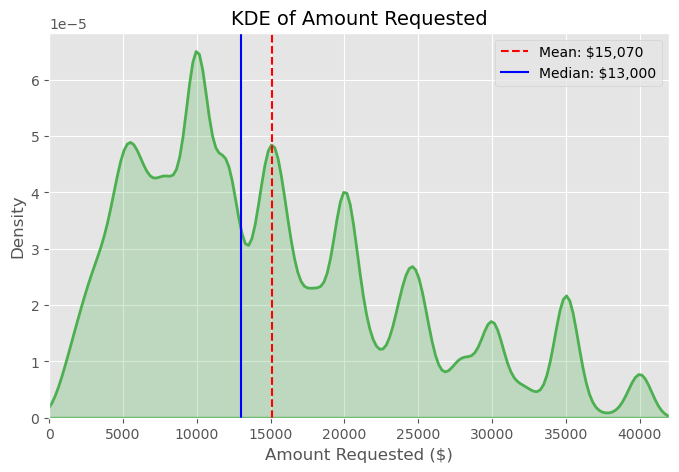

In [ ]:
# Calculate mean and median
amount_mean = accepted_sample['amount_requested'].mean()
amount_median = accepted_sample['amount_requested'].median()

# Plot KDE only
plt.figure(figsize=(8, 5))
sns.kdeplot(
    data=accepted_sample,
    x='amount_requested',
    color='#4CAF50',
    fill=True,        # fill under the curve
    linewidth=2
)

# Add mean and median lines
plt.axvline(amount_mean, color='red', linestyle='--', label=f'Mean: ${amount_mean:,.0f}')
plt.axvline(amount_median, color='blue', linestyle='-', label=f'Median: ${amount_median:,.0f}')

# Titles and labels
plt.title('KDE of Amount Requested', fontsize=14)
plt.xlabel('Amount Requested ($)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xlim(0, accepted_sample['amount_requested'].max()*1.05)
plt.ylim(0, None)  # y will start at 0
plt.legend()
plt.show()

> **Interpretation:** The KDE indicates that most loans are around $10,000, with a mean of $15,070 and a median of $13,000. High-value loans slightly skew the distribution.

##### 4. Save Updated Sample Datasets with Derived Columns
**Purpose**: After creating derived columns such as `loan_status_grouped`, it's important to save the updated sample datasets.  
This ensures that subsequent analysis in other notebooks can use the processed data directly without repeating transformations.

In [ ]:
# Save updated accepted loans sample
accepted_sample.to_csv('../data/sample_data/accepted_sample_processed.csv', index=False)


##### 5. Summary and Next Steps
##### Summary

- Successfully created stratified and random samples of both accepted loan dataset.
- Verified representativeness of samples through distribution and proportion checks.
- Performed numerical univariate analysis along with categorical feature exploration to identify key data patterns.
- Generated insights on borrower characteristics and loan trends relevant for credit risk analysis.

##### Next Steps

Moving forward, the next phase will involve:
- Conducting in-depth statistical EDA to explore relationships between features and loan outcomes.
- Handling missing values and outliers more contextually based on analytical needs.
- Creating derived and engineered variables to support predictive modeling.
- Developing visual dashboards and feature-level insights for stakeholder presentation.

The next phase will be documented in [`3_numerical_and_bivariate_EDA.ipynb`](3_numerical_and_bivariate_EDA.IPYNB)